In [4]:
#!/usr/bin/env python
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import numpy as np, os, sys
from tqdm.notebook import tqdm    
from manipulations import get_classes, get_classes_from_header, get_Fs_from_header, load_challenge_data

if __name__ == '__main__':
    
    Datas = []
    Header_datas = []
    Classes = []
    for dataset in range(1,7):
        print('Dataset ', dataset)
        # Parse arguments.
        if len(sys.argv) != 3:
            raise Exception('Include the input and output directories as arguments, e.g., python driver.py input output.')

        input_directory = '../Data/Training{}/'.format(dataset)
        output_directory = '../Output/'

        # Find files.
        input_files = []
        for f in os.listdir(input_directory):
            if os.path.isfile(os.path.join(input_directory, f)) and not f.lower().startswith('.') and f.lower().endswith('mat'):
                input_files.append(f)

        if not os.path.isdir(output_directory):
            os.mkdir(output_directory)

        classes=get_classes(input_directory,input_files)

        num_files = len(input_files)
        datas = []
        header_datas = []
        for i, f in tqdm(enumerate(input_files)):
            #print('    {}/{}...'.format(i+1, num_files), f)
            tmp_input_file = os.path.join(input_directory,f)
            data,header_data = load_challenge_data(tmp_input_file)
            datas.append(data)
            header_datas.append(header_data)

        Datas += datas
        Header_datas += header_datas
        Classes += classes
        print('Done.')

Dataset  1



Done.
Dataset  2



Done.
Dataset  3



Done.
Dataset  4



Done.
Dataset  5



Done.
Dataset  6



Done.


In [6]:
from global_vars import labels, Dx_map, Dx_map_unscored

In [7]:
Dx_map

,Dx,SNOMED CT Code,Abbreviation,CPSC,CPSC-Extra,StPetersburg,PTB,PTB-XL,Georgia,Total,Notes
0,1st degree av block,270492004,IAVB,722,106,0,0,797,769,2394,NaN
1,atrial fibrillation,164889003,AF,1221,153,2,15,1514,570,3475,NaN
2,atrial flutter,164890007,AFL,0,54,0,1,73,186,314,NaN
3,bradycardia,426627000,Brady,0,271,11,0,0,6,288,NaN
4,complete right bundle branch block,713427006,CRBBB,0,113,0,0,542,28,683,We score 713427006 and 59118001 as the same di...
5,incomplete right bundle branch block,713426002,IRBBB,0,86,0,0,1118,407,1611,NaN
6,left anterior fascicular block,445118002,LAnFB,0,0,0,0,1626,180,1806,NaN
7,left axis deviation,39732003,LAD,0,0,0,0,5146,940,6086,NaN
8,left bundle branch block,164909002,LBBB,236,38,0,0,536,231,1041,NaN
9,low qrs voltages,251146004,LQRSV,0,0,0,0,182,374,556,NaN


In [8]:
from manipulations import get_abbr, get_name
first_idx = {scored_code: None for scored_code in list(Dx_map['SNOMED CT Code'])}
first_idx_unscored = {unscored_code: None for unscored_code in list(Dx_map_unscored['SNOMED CT Code'])}

for i, Header_data in tqdm(enumerate(Header_datas)):
    codes = get_classes_from_header(Header_data)
    abbrs = ' '.join([get_abbr(int(code), Dx_map, Dx_map_unscored) for code in codes])
    for code, abbr in zip(codes, abbrs):
        if code in first_idx and first_idx[code] is None:
            first_idx[code] = i
        if code in first_idx_unscored and first_idx_unscored[code] is None:
            first_idx_unscored[code] = i
    encore = False
    for code in first_idx.keys():
        if first_idx[code] is None:
            encore = True
            break
    for code in first_idx_unscored.keys():
        if first_idx_unscored[code] is None:
            encore = True
            break
    if not encore:
        break

In [82]:
from signal_processing import myfilter, extract_QRST, main_QRST
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
qrs_chn = 12 # use the PCA of the frontal plane
for postfix in ['','_2']:
    for scored_code in tqdm(first_idx.keys()): # 

        idx = first_idx[scored_code]
        codes = get_classes_from_header(Header_datas[idx])
        names = ', '.join([get_name(int(code), Dx_map, Dx_map_unscored) for code in codes])

        if postfix == '':
            filtered_Data = myfilter(Datas[idx][:,1000:4000], 500, vis=False)
        else:
            filtered_Data = myfilter(Datas[idx][:,-4000:-1000], 500, vis=False)

        # get the lead to apply Pan Tomkins
        main_QRST(filtered_Data, idx, scored_code, postfix, names, fig2=True)

  


In [128]:
for postfix in ['']:
    for idx in tqdm(range(37581, len(Datas))): # 
        if np.sum(Datas[idx]) != 0:
            codes = get_classes_from_header(Header_datas[idx])
            names = ', '.join([get_name(int(code), Dx_map, Dx_map_unscored) for code in codes])

            filtered_Data = myfilter(Datas[idx][:,1000:4000], 500, vis=False)

            # get the lead to apply Pan Tomkins
            main_QRST(filtered_Data, idx, '', postfix, names, fig2=False)

In [122]:
idx

37581

# Examine sampled ecg

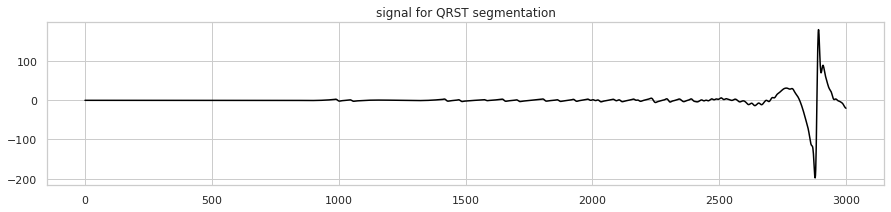

membership [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0]
big_members [2865 2875 2879 2893]
removed!!!!!!
membership [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0]
big_members [2837]
removed!!!!!!
membership [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1]
big_members [2976]
removed!!!!!!
membership [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0

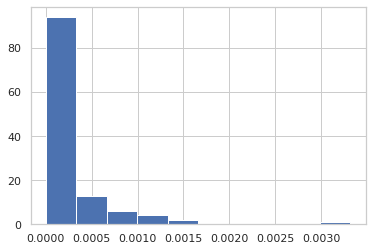

membership [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
gmm.means_ [[0.00028917]
 [0.0013498 ]]
threshold:0.0032863295569064504
threshold:0.0032863295569064504
left: [2798 2974] right: [2965 3025]
Q locations: [2798]
R locations: [2878]
S locations: [2891]
------------------
------report------
RR std nan
R_loc [2878]
------------------
------------------


/home/yfeng/anaconda3/envs/physioNet/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/yfeng/anaconda3/envs/physioNet/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/yfeng/anaconda3/envs/physioNet/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


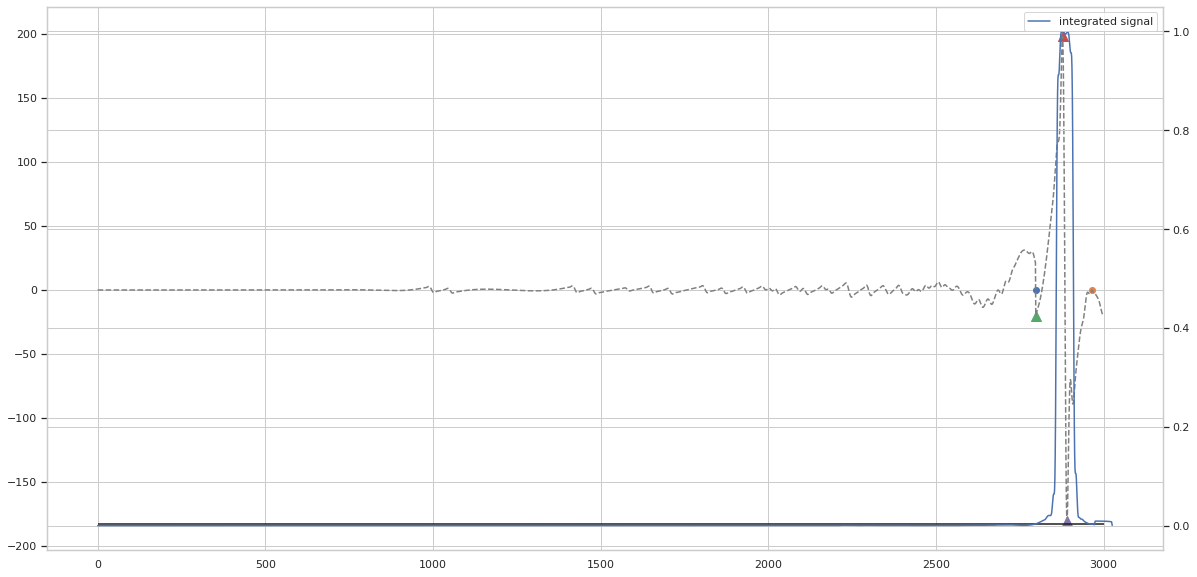

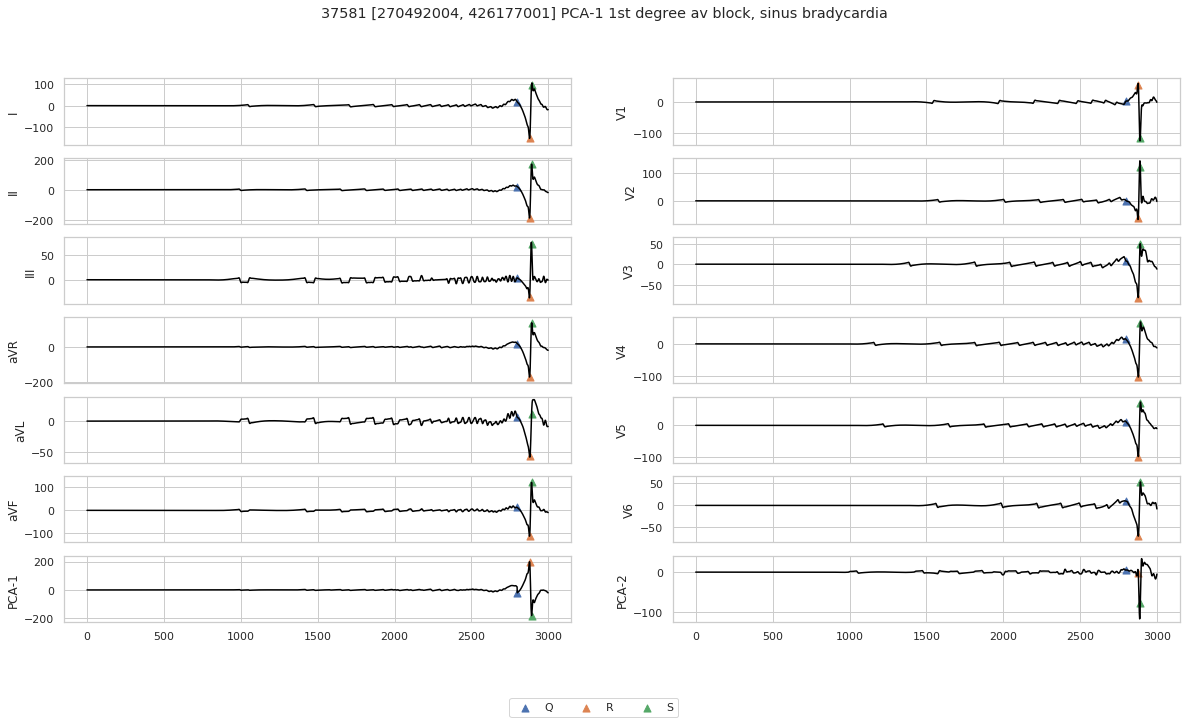

/home/yfeng/anaconda3/envs/physioNet/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yfeng/anaconda3/envs/physioNet/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


RR_avg nan RR_th (nan, nan)


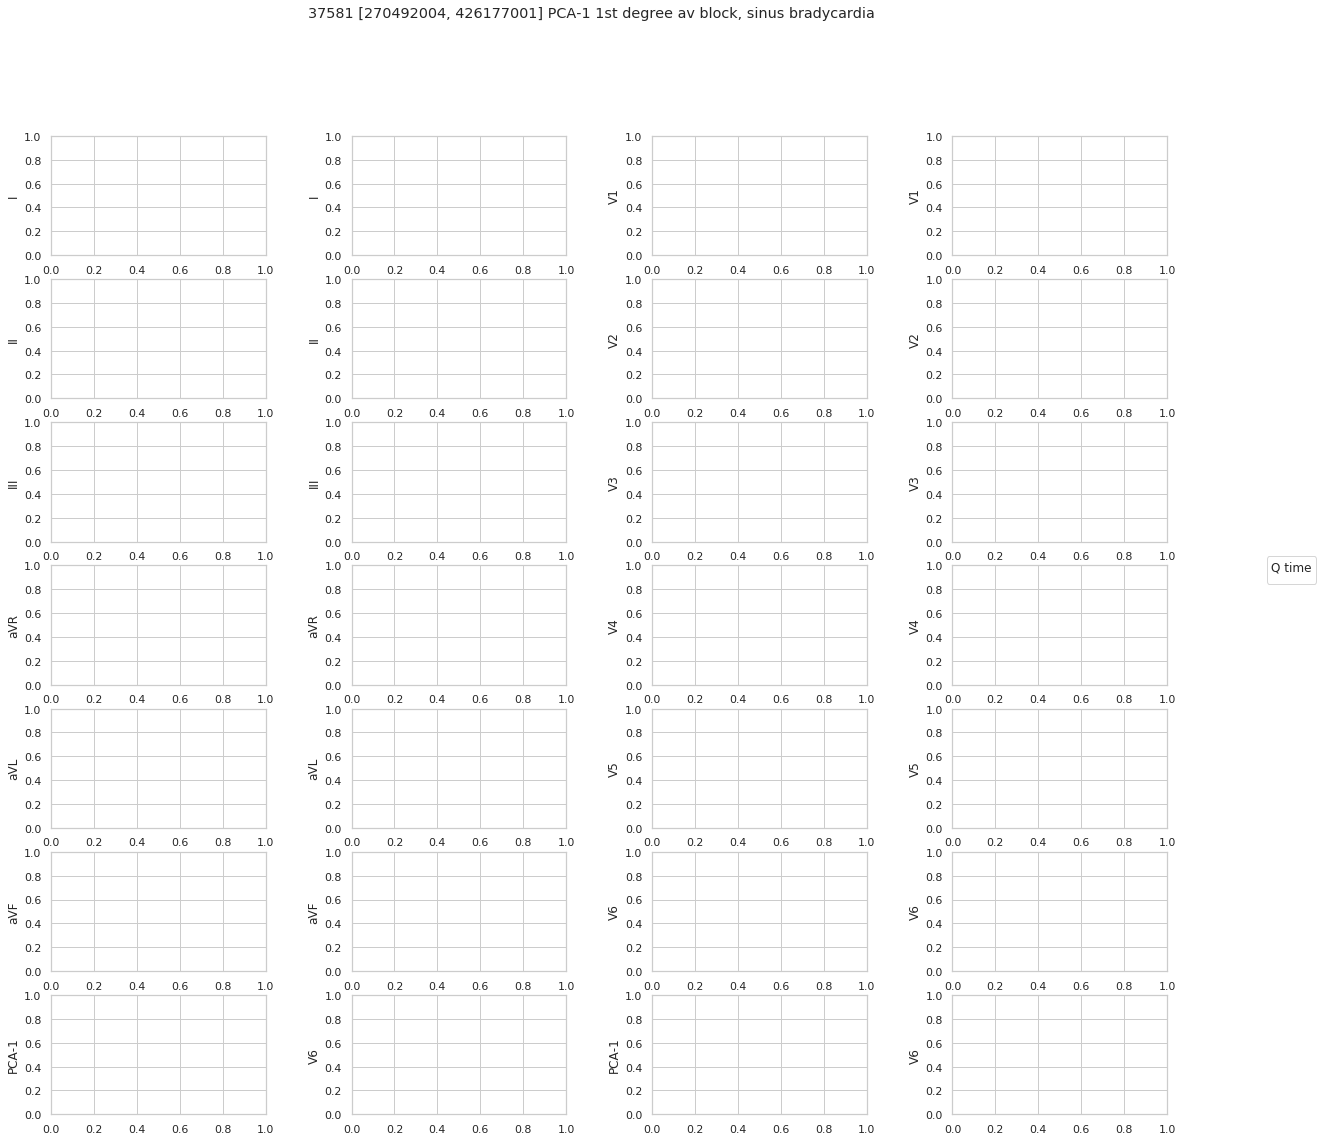

array([2798])

In [130]:
idx = 37581#2932#6884 #6884 #6951 #227#8074 #325#158#325#34#17#8659#4#18#61#10927#6886# 8659
codes = get_classes_from_header(Header_datas[idx])
names = ', '.join([get_name(int(code), Dx_map, Dx_map_unscored) for code in codes])
filtered_Data = myfilter(Datas[idx][:,1000:4000], 500, vis=False)
#filtered_Data = myfilter(Datas[idx][:,-4000:-1000], 500, vis=False)
main_QRST(filtered_Data, idx, codes, postfix, names, vis=True, verbose=True, fig1=True, fig2=True)

# LAD, RAD 

In [56]:
from signal_processing import find_AD
diagnoses = []
true_diagnoses = []
for i, Header_data in tqdm(enumerate(Header_datas)):
    
    ads = find_AD(Datas[i][:,:])
    codes = get_classes_from_header(Header_data)
    ####
    diagnosis = 0
    if ads == "LAD" :
        diagnosis = 1
    elif ads == "RAD" :
        diagnosis = 2
    diagnoses.append(diagnosis)
    ####
    true_diagnosis = 0
    if 39732003 in codes:
        true_diagnosis = 1
    elif 47665007 in codes:
        true_diagnosis = 2
    true_diagnoses.append(true_diagnosis)

In [9]:
TP_lad = len(np.argwhere((np.array(true_diagnoses)==1) * (np.array(diagnoses)==1)).flatten())
FP_lad = len(np.argwhere((np.array(true_diagnoses)!=1) * (np.array(diagnoses)==1)).flatten())
FN_lad = len(np.argwhere((np.array(true_diagnoses)==1) * (np.array(diagnoses)!=1)).flatten())
TN_lad = len(np.argwhere((np.array(true_diagnoses)!=1) * (np.array(diagnoses)!=1)).flatten())

In [10]:
TP_rad = len(np.argwhere((np.array(true_diagnoses)==2) * (np.array(diagnoses)==2)).flatten())
FP_rad = len(np.argwhere((np.array(true_diagnoses)!=2) * (np.array(diagnoses)==2)).flatten())
FN_rad = len(np.argwhere((np.array(true_diagnoses)==2) * (np.array(diagnoses)!=2)).flatten())
TN_rad = len(np.argwhere((np.array(true_diagnoses)!=2) * (np.array(diagnoses)!=2)).flatten())

In [11]:
np.argwhere((np.array(true_diagnoses)==2) * (np.array(diagnoses)!=2)).flatten()

array([ 8662, 10991, 11141, 11313, 11894, 12076, 13804, 13808, 14501,
       14560, 14866, 15505, 15992, 16138, 16393, 16413, 16454, 17131,
       17252, 17588, 17754, 17782, 17992, 18017, 18222, 18435, 18556,
       18766, 19603, 19617, 19641, 19796, 20135, 21219, 21571, 21690,
       21937, 21942, 22134, 22174, 22222, 22262, 22316, 22504, 22560,
       22578, 23158, 24504, 25063, 25994, 26516, 26863, 27243, 27264,
       27652, 27814, 28084, 28505, 28545, 29702, 29746, 29802, 29882,
       30198, 30220, 30490, 30515, 31076, 31077, 31078, 31242, 31488,
       31866, 31895, 31952, 32383, 32491, 32548, 32995, 33792, 34124,
       34139, 35493, 35924, 36260, 36328, 37058, 37342, 37623, 37803,
       38226, 38723, 39838, 39999, 40058, 40238, 40360, 41103, 41132,
       42992])

In [13]:
print("LAD", TP_lad, FP_lad, FN_lad, TN_lad)
print("RAD", TP_rad, FP_rad, FN_rad, TN_rad)

LAD 5625 9357 461 27658
RAD 327 1999 100 40675


In [14]:
print("acc", (TP_lad + TN_lad) / (TP_lad + FP_lad + FN_lad + TN_lad))
print("recall", (TP_lad ) / (TP_lad + FN_lad))
print("precision", (TP_lad ) / (TP_lad + FP_lad ))

acc 0.7722094614974131
recall 0.9242523825172527
precision 0.37545054064877853


In [15]:
print("acc", (TP_rad + TN_rad) / (TP_rad + FP_rad + FN_rad + TN_rad))
print("recall", (TP_rad ) / (TP_rad + FN_rad))
print("precision", (TP_rad ) / (TP_rad + FP_rad ))

acc 0.9513004338646435
recall 0.765807962529274
precision 0.14058469475494412


# CWT

In [188]:
for i in range(12):
    cwt(myfilter(Datas[7488][i,1000:4000],500), vis=True)
    

NameError: name 'cwt' is not defined

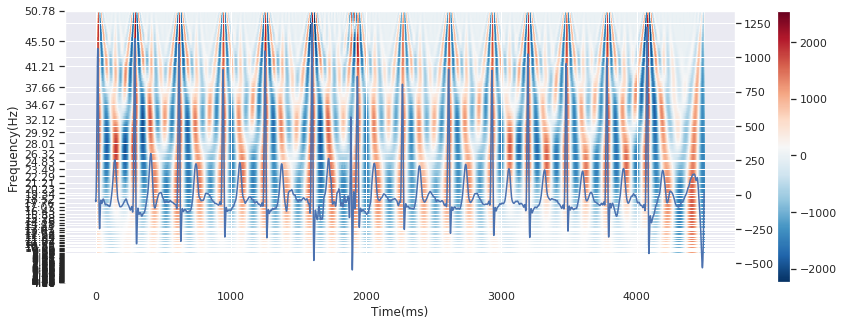

AFL


In [26]:
from signal_processing import cwt
idx = 7000
_=cwt(myfilter(Datas[idx][10,0:4500], 500), vis=True)
codes = get_classes_from_header(Header_datas[idx])
abbrs = ' '.join([get_abbr(int(code), Dx_map, Dx_map_unscored) for code in codes])
print(abbrs)